## Exploration of KernelSHAP with model (binary MNIST) converted from onnx to tf

**Function        : Exploration of KernelSHAP with model (binary MNIST) converted from onnx to tf**<br>
**Author          : Team DIANNA**<br>
**Contributor     :**<br>
**First Built     : 2021.12.09**<br>
**Last Update     : 2021.12.09**<br>
**Library         : os, numpy, matplotlib, tensorflow, keras, shap**<br>
**Description     : In this notebook we test XAI method KernelSHAP using trained binary MNIST model.**<br>
**Return Values   : Shapley scores**<br>
**Note**          : We use shap library, which is the original implementation by the author of "SHAP" paper, to perform KernelSHAP.<br>

In [1]:
from __future__ import print_function
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
import numpy as np
import shap
import matplotlib.pyplot as plt
from skimage.segmentation import slic
import warnings

In [2]:
# prepare binary mnist dataset

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# check the shape of train and test sets
print("Before filtering")
print("training set shape", x_train.shape)
print("training set label shape", y_train.shape)
print("testing set shape", x_test.shape)
print("testing set label shape", y_test.shape)
# get all the images labelled "0" and "1" (binary filtering)
label_a = 0
label_b = 1
x_train_binary = x_train[(y_train == label_a) | (y_train == label_b),:]
y_train_binary = y_train[(y_train == label_a) | (y_train == label_b)]
x_test_binary = x_test[(y_test == label_a) | (y_test == label_b),:]
y_test_binary = y_test[(y_test == label_a) | (y_test == label_b)]
# check the shape of train and test sets after filtering
print("After filtering")
print("training set shape", x_train_binary.shape)
print("training set label shape", y_train_binary.shape)
print("testing set shape", x_test_binary.shape)
print("testing set label shape", y_test_binary.shape)

Before filtering
training set shape (60000, 28, 28)
training set label shape (60000,)
testing set shape (10000, 28, 28)
testing set label shape (10000,)
After filtering
training set shape (12665, 28, 28)
training set label shape (12665,)
testing set shape (2115, 28, 28)
testing set label shape (2115,)


In [3]:
# define basic parameters of training
batch_size = 128
num_classes = 2
epochs = 10

# preprocess training and testing sets
if K.image_data_format() == 'channels_first':
    x_train_binary = x_train_binary.reshape(x_train_binary.shape[0], 1, img_rows, img_cols)
    x_test_binary = x_test_binary.reshape(x_test_binary.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train_binary = x_train_binary.reshape(x_train_binary.shape[0], img_rows, img_cols, 1)
    x_test_binary = x_test_binary.reshape(x_test_binary.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train_binary = x_train_binary.astype('float32')
x_test_binary = x_test_binary.astype('float32')
x_train_binary /= 255
x_test_binary /= 255
print('x_train_binary shape:', x_train_binary.shape)
print(x_train_binary.shape[0], 'train samples')
print(x_test_binary.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train_binary = keras.utils.to_categorical(y_train_binary, num_classes)
y_test_binary = keras.utils.to_categorical(y_test_binary, num_classes)

x_train_binary shape: (12665, 28, 28, 1)
12665 train samples
2115 test samples


In [4]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

2022-01-03 17:49:12.683825: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-03 17:49:12.684215: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-03 17:49:12.685337: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [5]:
model.fit(x_train_binary, y_train_binary,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test_binary, y_test_binary))
score = model.evaluate(x_test_binary, y_test_binary, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

2021-12-09 12:21:46.642986: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-12-09 12:21:46.643706: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2304005000 Hz


Epoch 1/2
99/99 [==============================] - 18s 177ms/step - loss: 0.6926 - accuracy: 0.5235 - val_loss: 0.6692 - val_accuracy: 0.9480
Epoch 2/2
99/99 [==============================] - 14s 144ms/step - loss: 0.6649 - accuracy: 0.7539 - val_loss: 0.6392 - val_accuracy: 0.9844
Test loss: 0.6391953229904175
Test accuracy: 0.9843971729278564


In [5]:
# save model
savedmodel_dir = 'mnist_savedmodel'
#model.save(savedmodel_dir)

In [7]:
# convert model to onnx format
import onnx
onnx_savedmodel = 'mnist_savedmodel.onnx'
!python -m tf2onnx.convert --saved-model {savedmodel_dir} --output {onnx_savedmodel} --signature_def serving_default --tag serve

/home/yangliu/miniconda3/lib/python3.8/runpy.py:127: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2022-01-03 17:49:37,681 - INFO - Signatures found in model: [serving_default].
2022-01-03 17:49:37,681 - INFO - Output names: ['dense_1']
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
2022-01-03 17:49:37,818 - WARNING - From /home/yangliu/miniconda3/lib/python3.8/site-packages/tf2onnx/tf_loader.py:706: extract_sub_graph (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
2022-01-03 17:49:37,911 - INFO - Using tensorflow=2.4.1, onnx=1.9.0, tf2onnx=1.9.3/1190aa
2022-01-03 17:49:37,912 - INFO - Using opset <onnx, 9>
2022-01-03 17:49:38,144 - INFO - Computed 0 values for constant 

In [8]:
import onnxruntime as ort
from onnx_tf.backend import prepare
# Load saved onnx model and convert it back to keras/tf model
onnx_model = onnx.load("mnist_savedmodel.onnx")  # load onnx model

### Overview of tf model re-loaded from onnx format (not required step for the whole workflow)
We can check the tf model converted back from onnx format. The following commands will do the job for you. But this part is not necessary for the execution/creation of model runner to perform kernel shap. 

In [9]:
# overview of loaded 
tf_model_rep = prepare(onnx_model, gen_tensor_dict=True)
print(tf_model_rep.inputs) # Input nodes to the model
print('-----')
print(tf_model_rep.outputs) # Output nodes from the model
print('-----')
print(tf_model_rep.tensor_dict) # All nodes in the model
# load tf model from exported graph
#tf_model_rep.export_graph("mnist_model_graph")
#tf_model = tf.saved_model.load("mnist_model_graph")
#tf_model = tf.keras.models.load_model("mnist_model_graph") # keras model loader

['conv2d_input']
-----
['dense_1']
-----
{'conv2d_input': <tf.Tensor 'conv2d_input:0' shape=(None, 28, 28, 1) dtype=float32>, 'new_shape__19': <tf.Variable 'new_shape__19:0' shape=(4,) dtype=int64>, 'const_fold_opt__20': <tf.Variable 'const_fold_opt__20:0' shape=(2,) dtype=int64>, 'StatefulPartitionedCall/sequential/dense_1/MatMul/ReadVariableOp:0': <tf.Variable 'StatefulPartitionedCall/sequential/dense_1/MatMul/ReadVariableOp_tf_0_ff6b2649:0' shape=(128, 2) dtype=float32>, 'StatefulPartitionedCall/sequential/dense_1/BiasAdd/ReadVariableOp:0': <tf.Variable 'StatefulPartitionedCall/sequential/dense_1/BiasAdd/ReadVariableOp_tf_0_74b81394:0' shape=(2,) dtype=float32>, 'StatefulPartitionedCall/sequential/dense/MatMul/ReadVariableOp:0': <tf.Variable 'StatefulPartitionedCall/sequential/dense/MatMul/ReadVariableOp_tf_0_00b2a6d5:0' shape=(9216, 128) dtype=float32>, 'StatefulPartitionedCall/sequential/dense/BiasAdd/ReadVariableOp:0': <tf.Variable 'StatefulPartitionedCall/sequential/dense/BiasAd

skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.


(-0.5, 27.5, 27.5, -0.5)

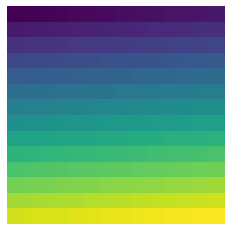

In [10]:
# Create segmentation to explain by segment, not every pixel
segments_slic = slic(x_test_binary[1,:,:,:], n_segments=200, compactness=20, sigma=0)

plt.imshow(segments_slic)
plt.axis('off')

In [11]:
# define a function that depends on a binary mask representing if an image region is hidden
def mask_image(zs, segmentation, image, background=None):
    
    if background is None:
        background = image.mean((0, 1))
        
    # Create an empty 4D array
    out = np.zeros((zs.shape[0], 
                    image.shape[0], 
                    image.shape[1], 
                    image.shape[2]))
    
    for i in range(zs.shape[0]):
        out[i, :, :, :] = image
        for j in range(zs.shape[1]):
            if zs[i, j] == 0:
                out[i][segmentation == j, :] = background
    return out.astype(np.float32)

def f(z):
    # it is better to find a generic way to load the values
    return prepare(onnx_model).run(
        mask_image(z, segments_slic, x_test_binary[1,:,:,:], 0)).dense_1 # better replace "dense_1" with some generic entry
        
def fill_segmentation(values, segmentation):
    out = np.zeros(segmentation.shape)
    for i in range(len(values)):
        out[segmentation == i] = values[i]
    return out

(-0.5, 27.5, 27.5, -0.5)

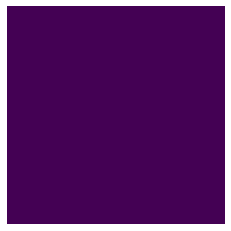

In [12]:
masked_images = mask_image(np.zeros((1,200)), segments_slic, x_test_binary[1,:,:,:], 0)

plt.imshow(masked_images[0][:,:,0])
plt.axis('off')

In [13]:
# use Kernel SHAP to explain the network's predictions
explainer = shap.KernelExplainer(f, np.zeros((1,200)))

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shap_values = explainer.shap_values(np.ones((1,200)), nsamples=1000)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-01-03 17:50:34.192713: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-01-03 17:50:34.194014: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2304005000 Hz


  0%|          | 0/1 [00:00<?, ?it/s]

In [14]:
predictions = prepare(onnx_model).run(np.expand_dims(x_test_binary[1,:,:,:].copy(), axis=0)).dense_1
top_preds = np.argsort(-predictions)

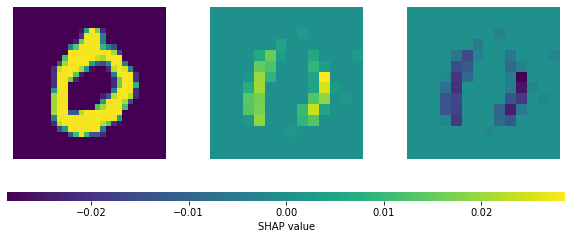

In [15]:
# Visualize the explanations
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,4))
inds = top_preds[0]
axes[0].imshow(x_test_binary[1,:,:,:])
axes[0].axis('off')

max_val = np.max([np.max(np.abs(shap_values[i][:,:-1])) for i in range(len(shap_values))])
for i in range(2):
    m = fill_segmentation(shap_values[inds[i]][0], segments_slic)
    #axes[i+1].set_title(feature_names[str(inds[i])][1])
    axes[i+1].imshow(x_test_binary[1,:,:,:], alpha=0.15)
    im = axes[i+1].imshow(m, vmin=-max_val, vmax=max_val)
    axes[i+1].axis('off')
cb = fig.colorbar(im, ax=axes.ravel().tolist(), label="SHAP value", orientation="horizontal", aspect=60)
cb.outline.set_visible(False)
plt.show()